In [1]:
import numpy as np
import pandas as pd
from scipy import io
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns
import scipy
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Feature_dataset.csv')
label_data = pd.read_csv('label_valence.csv')

In [3]:
data

,MEAN,MED,MIN,MAX,STD,VAR,SKW,KURT,SE,LEE,PEAKS
0,375360.503664,378831.032486,-25212.644397,404458.558442,19148.071055,3.666486e+08,-3.998082,68.427342,18.813147,-9.406574,2825
1,414545.406197,413947.983165,367322.652605,475720.249705,30325.434445,9.196320e+08,0.453521,-0.827522,17.750236,-8.875118,1714
2,357804.430349,365321.709630,272774.357528,415386.030442,38342.335960,1.470135e+09,-0.601898,-0.661127,19.267139,-9.633569,3690
3,270967.004896,266974.123043,118824.844400,426344.200570,35526.441049,1.262128e+09,0.131543,-1.228120,18.464975,-9.232487,2405
4,292836.248774,293589.005572,118920.693012,346159.579310,30110.284158,9.066292e+08,-0.337374,-0.406457,19.332744,-9.666372,3625
...,...,...,...,...,...,...,...,...,...,...,...
795,192054.013798,194004.549114,149325.552113,214717.920548,13372.177847,1.788151e+08,-0.824149,0.694542,18.326404,-9.163202,2247
796,285701.158252,284697.611521,118401.111153,456973.042700,64165.276738,4.117183e+09,0.228767,-0.326074,24.030493,-12.015247,42154
797,287911.523148,286234.551419,118530.660622,407168.808085,41971.664507,1.761621e+09,0.084164,-0.319896,23.677859,-11.838929,33445
798,213977.735532,190462.095798,107308.650051,358025.496935,66646.807769,4.441797e+09,0.546717,-1.008389,23.853941,-11.926971,42903


In [4]:
# HV = 1, LV = 0 
label_data

,valence
0,1.0
1,1.0
2,0.0
3,1.0
4,0.0
...,...
783,1.0
784,0.0
785,1.0
786,1.0


In [5]:
remove32 = data.drop(index = [636,637,638,639]) # 32번 참가자의 label 데이터가 없으므로 삭제하여 데이터 수 맞춰줌
feature_data = remove32.dropna(axis=0) # GSR 신호가 없는 행 삭제 
label = label_data.drop(index = [548,549,550,551]) # 28번 참가자의 GSR신호가 없으므로 해당 동영상 label 삭제하여 데이터 수 맞춰줌

In [6]:
X = feature_data.values
y = label.values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [8]:
X_train.shape

(627, 11)

## Valence Binary classification

## XGBoost

In [9]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

xgb_param_grid = {'max_depth': [3,5,7], 
              'subsample': [0.6, 0.8, 1.0]}

grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring='roc_auc', n_jobs=8, cv=5, return_train_score=True)


grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

[22:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'max_depth': 3, 'subsample': 1.0}
0.7871790453594538


## LinearSVM

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

SVCpipe = Pipeline([('scale', StandardScaler()),
                  ('SVC',LinearSVC())])


param_grid = {'SVC__C':np.arange(0.01,1000,10)}
grid = GridSearchCV(SVCpipe,param_grid, cv=5,return_train_score=True)
grid.fit(X_train,y_train)
print(grid.best_score_)
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

0.5868698412698412
              precision    recall  f1-score   support

         0.0       0.67      0.03      0.06        63
         1.0       0.60      0.99      0.75        94

    accuracy                           0.61       157
   macro avg       0.64      0.51      0.41       157
weighted avg       0.63      0.61      0.47       157



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


rf = Pipeline([('scale', RobustScaler()),
('RandomForest',RandomForestClassifier(random_state = 0))])


param_grid = {'RandomForest__n_estimators': np.arange(10,120,5),'RandomForest__max_depth': np.arange(3,7)}
grid = GridSearchCV(rf,param_grid, cv=5,return_train_score=True)

grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

{'RandomForest__max_depth': 4, 'RandomForest__n_estimators': 20}
0.7416126984126983
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68        63
         1.0       0.78      0.78      0.78        94

    accuracy                           0.74       157
   macro avg       0.73      0.73      0.73       157
weighted avg       0.74      0.74      0.74       157



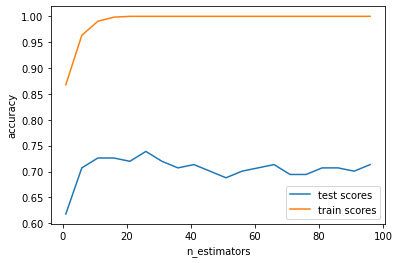

In [12]:
rf = RandomForestClassifier(random_state=0)
train_scores = []
test_scores = []

estimator_range = range(1, 100, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()
